In [18]:
from langgraph.graph import StateGraph, START , END
from langchain_openai import ChatOpenAI
from typing import TypedDict , Annotated
from dotenv import load_dotenv
from pydantic import BaseModel , Field
import operator


In [19]:
load_dotenv()

True

In [20]:
import os
api_key = os.environ.get("PERPLEXITY_API_KEY")


In [21]:
model = ChatOpenAI(
    api_key=api_key,
    base_url="https://api.perplexity.ai",
    model="sonar-pro"  # or another supported Perplexity model
)

In [22]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description = 'detailed feedback for essay')
    score:int = Field(description='Score out of 10', ge = 0 , le= 10)

In [23]:
structured_model = model.with_structured_output(EvaluationSchema)

In [24]:
essay = """The Role of India in Artificial Intelligence: Shaping the Present and Future

In the past decade, India has emerged as a vital, dynamic force in the global landscape of artificial intelligence (AI). Once seen as a technology consumer, India is now an innovator, ecosystem builder, and advocate for democratized, responsible AI. This remarkable trajectory stems from a unique confluence of government vision, entrepreneurial energy, world-class talent, and the country’s emphasis on inclusivity and public good.

1. Vision and Strategy: Democratizing AI for All
Unlike approaches centered solely on commerce or military use, India’s strategy roots itself in “AI for All”—seeking to ensure access, opportunity, and benefit across all strata of society. The government’s IndiaAI Mission (launched in 2024 with over ₹10,300 crore committed over five years) is constructing one of the world’s strongest foundations for AI, from massive GPU compute infrastructure to high-quality, anonymized datasets. Programs like Centres of Excellence in AI, the IndiaAI Dataset Platform (AIKosh), and public-good initiatives reinforce this approach, making advanced AI hardware and data accessible to startups, researchers, and students, not just tech giants or a privileged few.

India’s Digital Public Infrastructure serves as a global model by combining public funding and private innovation: foundational digital platforms like Aadhaar, UPI, and DigiLocker are now being “supercharged” with AI, inspiring adoption around the world.

2. Fostering Innovation and Indigenous Foundations
India’s push to develop homegrown foundational AI models is gaining momentum. The IndiaAI Innovation Initiative invites startups, labs, and academic researchers to build Large Language Models (LLMs) and domain-specific solutions tailored to India’s 23 major languages and distinctive societal needs. This not only addresses global challenges of linguistic diversity and cultural nuance in AI, but also fosters strategic autonomy—reducing reliance on foreign AI models.

More than 500 proposals for foundational models have been submitted by Indian startups and researchers in 2025 alone—an extraordinary outpouring of grassroots innovation.

3. Talent Engine and Global Influence
India boasts the highest AI skill penetration in the world, and a talent pipeline growing at breakneck speed. With over 420,000 AI professionals and widespread upskilling programs, India is recognized as a global AI talent hub. The affordable, abundant talent pool enables Indian startups not only to serve the domestic market but to create AI products for the world—making India the second-largest contributor to GitHub AI projects.

4. Economic and Societal Impact
By 2025, India’s AI sector is expected to contribute $500 billion to GDP, with industry bodies and global consultancies predicting millions of new, high-value jobs in the coming decade. AI is already transforming sectors crucial to India’s development: smart agriculture, affordable healthcare, inclusive education, urban planning, and secure financial services. As a “third way” between East and West, India’s AI model balances growth ambition with an ethos of ethical and inclusive AI, and carbon-neutral digital progress.

5. Global Engagement and Responsible AI
India is deeply engaged in shaping international AI norms. As co-chair of the Global Partnership on AI and through forums like the AI Governance Alliance, India champions “ethics by design,” data privacy safeguards, and AI for social good. Initiatives like RAISE (Responsible AI for Social Empowerment) exemplify this stance.

6. Challenges and the Road Ahead
India’s massive scale presents both opportunity and challenge. While there is a surge in innovation, addressing ethical, privacy, and security concerns, as well as bridging the digital skills gap, remain ongoing priorities. The government continues to invest in upskilling; legal frameworks are being adapted to keep pace with technology.

Conclusion
India’s role in artificial intelligence is no longer peripheral—it is central, visionary, and deeply human-centric. By combining indigenous innovation with global collaboration and ethical leadership, India is not only transforming its economy and society but also offering an inclusive, responsible model for the world as AI reshapes humanity’s future"""

In [25]:
prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
structured_model.invoke(prompt).feedback

'Overall assessment: Clear, confident, and well-structured prose with strong cohesion and varied sentence craft. Tone is professional and persuasive. However, the essay occasionally overreaches with unsubstantiated superlatives, includes a few punctuation/formatting inconsistencies, and could improve concision, evidence attribution, and hedging. Below is targeted language feedback.\n\nStrengths\n- Organization and flow\n  - Logical macro-structure with numbered sections and an effective introduction-to-conclusion arc.\n  - Clear section headers that align with claims, aiding readability.\n- Style and clarity\n  - Consistently precise, reader-friendly sentences with good verb choices (e.g., “emerged,” “supercharged,” “fosters”).\n  - Effective use of parallelism and thematic repetition (“AI for All,” “responsible AI”) to reinforce key messages.\n  - Strong topic sentences and transitions maintain coherence between paragraphs.\n- Tone and register\n  - Professional, confident, and policy

In [26]:
class UPSCState(TypedDict):
    essay : str
    language_feedback:str
    analysis_feedback:str
    clarity_feedback: str
    overall_feedback:str
    individual_scores:Annotated[list[int], operator.add] #reducer function
    avg_score: float

In [27]:
def evaluate_language(state:UPSCState):
    prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'language_feedback':output.feedback , 'individual_scores':[output.score]}


In [28]:
def evaluate_analysis(state:UPSCState):
    prompt = f'Evaluate the  depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'analysis_feedback':output.feedback , 'individual_scores':[output.score]}


In [29]:
def evaluate_thought(state:UPSCState):
    prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output = structured_model.invoke(prompt)

    return {'clarity_feedback':output.feedback , 'individual_scores':[output.score]}


In [30]:
def final_evaluation(state:UPSCState):
    #summary feedback 

    prompt = f'based on the following feedbacks create a summarised feedback \n language feedback - {state['language_feedback']} ,depth of analysis feedback - {state['analysis_feedback']} , clarity of thought feedback - {state['clarity_feedback']}'
    overall_feedback = model.invoke(prompt).content

    # avg calculation 

    avg_score = sum(state['individual_scores']) / len(state['individual_scores'])

    return {'overall_feedback':overall_feedback ,'avg_score':avg_score}

In [31]:
# create the graph 
graph = StateGraph(UPSCState)

#add the nodes 
graph.add_node('evauate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_thought',evaluate_thought)
graph.add_node('final_evaluation',final_evaluation)

# add the edges 
graph.add_edge(START , 'evauate_language')
graph.add_edge(START , 'evaluate_analysis')
graph.add_edge(START , 'evaluate_thought')
graph.add_edge('evauate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thought','final_evaluation')
graph.add_edge('final_evaluation',END)


# excute the graph 
workflow = graph.compile()

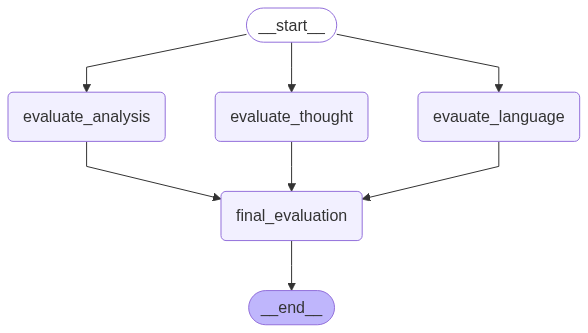

In [32]:
workflow

In [33]:
essay2 = """AI is like robots and computers that can think by themselves. In India, AI is getting more famous. I think in the future lots of people will use AI for many things. AI can help in school to do homework and even talk to us when no friends are there. Sometimes, AI can play games with us and tell us funny jokes, but sometimes it says weird things. My papa said AI can drive cars and maybe fix houses. AI also helps doctors to cure sick people and helps police catch bad guys, maybe.

In India, AI will make everything better and easier. People will not need to go to work because AI will do all the work. Farmers will use robot cows and robot tractors because AI knows how to plant seeds. If someone is lazy, AI can do work for them and we can play more and watch cartoons more. In the future, maybe we have robot teachers and flying cars in all cities. AI is super smart but sometimes gets confused if we ask hard questions.

My friend says AI is dangerous but I think it is nice because it tells me stories and helps me count candies. One day, maybe everyone will have a robot friend with AI and we will never be bored.

That is why I think AI is good and will help people in India. I don’t know much but maybe AI will make everyone happy, and nobody will have to do boring things anymore.'"""

In [34]:
initial_state = {
    'essay':essay2
}

workflow.invoke(initial_state)

{'essay': "AI is like robots and computers that can think by themselves. In India, AI is getting more famous. I think in the future lots of people will use AI for many things. AI can help in school to do homework and even talk to us when no friends are there. Sometimes, AI can play games with us and tell us funny jokes, but sometimes it says weird things. My papa said AI can drive cars and maybe fix houses. AI also helps doctors to cure sick people and helps police catch bad guys, maybe.\n\nIn India, AI will make everything better and easier. People will not need to go to work because AI will do all the work. Farmers will use robot cows and robot tractors because AI knows how to plant seeds. If someone is lazy, AI can do work for them and we can play more and watch cartoons more. In the future, maybe we have robot teachers and flying cars in all cities. AI is super smart but sometimes gets confused if we ask hard questions.\n\nMy friend says AI is dangerous but I think it is nice becau